# NOS.nl - Text Classification

_Author: Gerben Tempelman_ <br>
_Date: 01-03-2019_ 

The objective of this project is to create a text classification model to classify news articles (documents) into news categories, and apply an unsupervised technique to visualize all articles. This will be done based on news articles from www.nos.nl. My personal goal is to explore techniques such as web-scraping, TF-IDF, Latent Dirichlet Allocation, Word Embedding, dimensionality reduction (t-sne & UMAP), and multinomial classifiers. This notebook will not go into much of the theory behind these techniques.

## Table of Contents: <br>

#### 1. Get data (Web Scraping)
#### 2. Cleaning data
#### 3. Feature Engineering

- 3.1 Bag of Words <br>
- 3.2 Term Frequency - Inverse Document Frequency (TF-IDF) <br>
- 3.3 Averaged Word Embeddings <br>
- 3.4 Topic Models (Latent Dirichlet Allocation) <br>
- 3.5 Doc2Vec

#### 4. Model Building
#### 5. Dimensionality Reduction and Visualization

__About NOS__:
_As the largest news organization of the Netherlands, the NOS offers reliable, independent round-the-clock reporting on news, current affairs, sports and national and international events. The NOS does this within the framework of the Dutch public broadcasting system and through a wide array of platforms: television, radio, online (www.nos.nl), mobile apps, teletext, smart tv’s, game consoles, narrow-casting and social networks. All of this makes the NOS the premier source of information in the Netherlands._

## 1. Get data (Web Scraping)

First, let's acquire the data. A web-scraper was constructed that gets all news articles - from all categories - of the year 2018. The code of the web-scraper is not shown and is available on request (as is the dataframe that is imported). The objective of the scraper was to put the result into a dataframe based on which features can be build for a text classification model. Contents of quote blocks, article titles and photo- and video subscripts of the news articles are omitted, since we want to process the data in its most unedited format. The 'Text' column will represent the corpus and the 'Category' column the target to be predicted. 

In [1]:
## Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import html
import seaborn as sns
from seaborn import set_style
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_colwidth", 200)

In [2]:
# Import data
df = pd.read_csv("../Datasets/NOS.csv")

print("Dataframe with the scraped content has {} rows and {} columns".format(df.shape[0], df.shape[1]))
df.sample(frac=1).head(5)

Dataframe with the scraped content has 29588 rows and 5 columns


,Title,Date,Link,Text,Category
19983,Belastingdienst kan plannen niet uitvoeren door aanhoudende ict-malaise,2018-04-17,https://www.nos.nl/artikel/2227840-belastingdienst-kan-plannen-niet-uitvoeren-door-aanhoudende-ict-malaise.html,"Nog altijd zijn de ict-problemen bij de Belastingdienst niet opgelost. Vanwege deze problemen worden plannen om terugbetalingsregelingen voor bijvoorbeeld zorg- of huurtoeslag te vereenvoudigen, v...",politiek
28218,"Bannon laat zich ondervragen, maar niet door grand jury",2018-01-17,https://www.nos.nl/artikel/2212434-bannon-laat-zich-ondervragen-maar-niet-door-grand-jury.html,"Steve Bannon, oud-adviseur van president Trump, is bereid zich achter gesloten deuren te laten ondervragen over mogelijke Russische bemoeienis met de Amerikaanse verkiezingen. Hij heeft daarover e...",buitenland
28982,De dagen van Klaassen bij Everton lijken geteld,2018-01-09,https://www.nos.nl/artikel/2211125-de-dagen-van-klaassen-bij-everton-lijken-geteld.html,"""Alles is daar voetbal en dat sprak me heel erg aan. Ik had meteen het gevoel: hier kan ik me echt gaan thuis voelen."" Het zijn de woorden van Davy Klaassen, op 15 juni 2017, kort na zijn overstap...",sport
9661,"Als het aan Ryanair-baas O'Leary ligt, betaal je straks ook voor de wc",2018-08-24,https://www.nos.nl/artikel/2247353-als-het-aan-ryanair-baas-o-leary-ligt-betaal-je-straks-ook-voor-de-wc.html,"""Het liefst zou ik een vliegtuig creëren waarin we de achterste tien rijen weg kunnen halen. Op die plek plaatsen we dan rails aan de zijkant. Dan zeggen we: als je staat, hoef je maar 5 euro te b...",binnenland
7114,Dumoulin na tweede plaats: 'Zat totaal mislukt op de fiets',2018-09-26,https://www.nos.nl/artikel/2252206-dumoulin-na-tweede-plaats-zat-totaal-mislukt-op-de-fiets.html,"Tom Dumoulin liep strompelend rond na zijn tijdrit op de WK wielrennen. Hij raakte verkrampt tijdens zijn rit over het 52,5 kilometer lange parcours in Innsbruck en verloor zijn titel aan Rohan De...",sport


The NOS provides a service called "waking service" ("wekdienst" in dutch), which is an early-morning overview of the events that happened the day before or early that day. Since these articles contain a mix of categories, this will confound the accuracy of the classifier. Therefore, we will find and omit these records.

In [3]:
print("{} records that contain 'wekdienst'".format(df[df['Link'].str.contains('wekdienst')].shape[0]))
pd.DataFrame(df[df['Link'].str.contains('wekdienst')]).head()

364 records that contain 'wekdienst'


,Title,Date,Link,Text,Category
36,Wekdienst 31/12: stapels oliebollen en knallende kurken,2018-12-31,https://www.nos.nl/artikel/2265657-wekdienst-31-12-stapels-oliebollen-en-knallende-kurken.html,Goedemorgen! Het is Oudjaarsdag en dat betekent dat je vanaf 18.00 uur legaal vuurwerk mag afsteken. Guido Weijers (RTL 4) en Marc-Marie Huijbregts (NPO 1) verzorgen beiden een oudejaarsconference...,binnenland
82,Wekdienst 30/12: presidentsverkiezingen in Congo en NK schaatsen,2018-12-30,https://www.nos.nl/artikel/2265535-wekdienst-30-12-presidentsverkiezingen-in-congo-en-nk-schaatsen.html,Goedemorgen! Vandaag zijn de presidentsverkiezingen in Congo en op het NK afstanden in Heerenveen wordt onder meer de 5 kilometer voor vrouwen en de 10 kilometer voor mannen geschaatst.Het blijft ...,binnenland
139,"Wekdienst 29/12: stille tocht in Rotterdam, gele hesjes en NK schaatsen",2018-12-29,https://www.nos.nl/artikel/2265421-wekdienst-29-12-stille-tocht-in-rotterdam-gele-hesjes-en-nk-schaatsen.html,Goedemorgen! Er wordt vandaag een stille tocht georganiseerd ter nagedachtenis van drie vermoorde vrouwen in Rotterdam. In Frankrijk gaan de gele hesjes weer de straat op en schaatsliefhebbers kun...,binnenland
209,Wekdienst 28/12: start vuurwerkverkoop en Nederland is pessimistischer,2018-12-28,https://www.nos.nl/artikel/2265289-wekdienst-28-12-start-vuurwerkverkoop-en-nederland-is-pessimistischer.html,Goedemorgen! Vanaf vandaag is het drie dagen legaal om vuurwerk te kopen en de schaatsers komen in actie op het NK Afstanden.Het is vandaag grotendeels bewolkt. Alleen in het zuidoosten is er kans...,binnenland
269,Wekdienst 27/12: ADM-terrein moet leeg en Van Gerwen op WK darts,2018-12-27,https://www.nos.nl/artikel/2265170-wekdienst-27-12-adm-terrein-moet-leeg-en-van-gerwen-op-wk-darts.html,"Goedemorgen! De gemeente Amsterdam controleert of alle bewoners van het gekraakte ADM-terrein zijn vertrokken, zo niet dan volgt een ontruiming. En Michael van Gerwen neemt het op het WK darts op ...",binnenland


In [4]:
df = df[~df['Link'].str.contains('wekdienst')]

The dataframe that was scraped is sorted by date. We will shuffle the dataframe randomly to prevent certain topics to be only in the training set.

In [5]:
# remove records with no text
print("{} records with no text were removed".format(df.loc[df.Text.isna()].shape[0]))
df = df.loc[~df.Text.isna()]

# shuffle data
df = df.sample(frac=1, random_state = 77).reset_index(drop=True)
df.index = range(df.shape[0]) #reindex
df.head()

3 records with no text were removed


,Title,Date,Link,Text,Category
0,Na vertrek Keizer staat Damien Hertog plots aan het roer bij Al-Jazira,2018-11-27,https://www.nos.nl/artikel/2261038-na-vertrek-keizer-staat-damien-hertog-plots-aan-het-roer-bij-al-jazira.html,"Na een kortstondig avontuur als hoofdtrainer van Ajax trok Marcel Keizer afgelopen zomer naar het Midden-Oosten. Hij werd trainer van Al-Jazira, een topclub in de Verenigde Arabische Emiraten (VAE...",sport
1,"Eerst waren de Saudische miljarden welkom, nu is de techwereld stil",2018-10-23,https://www.nos.nl/artikel/2256069-eerst-waren-de-saudische-miljarden-welkom-nu-is-de-techwereld-stil.html,De afgelopen jaren stonden techbedrijven in de rij om financiering te krijgen van Saudi-Arabië. Vele miljarden vloeiden vanuit het olierijke land naar de westkust van Amerika. Met de dood van jour...,economie
2,Duitse minister: ondertekenen migratiepact desnoods uitstellen,2018-11-19,https://www.nos.nl/artikel/2259899-duitse-minister-ondertekenen-migratiepact-desnoods-uitstellen.html,In Duitsland neemt de weerstand tegen het VN-migratiepact toe. Naast de rechts-populistische partij AfD roeren ook steeds meer leden vanuit de partij van bondskanselier Merkel CDU zich tegen de on...,buitenland
3,Buijs hekelt gedrag Gözübüyük na terugdraaien rood bij VVV-FC Groningen,2018-12-09,https://www.nos.nl/artikel/2262753-buijs-hekelt-gedrag-gozubuyuk-na-terugdraaien-rood-bij-vvv-fc-groningen.html,Serdar Gözübüyük wist de schijnwerpers op zich gericht tijdens de weinig verheffende remise tussen VVV-Venlo en FC Groningen (0-0). De scheidsrechter verbaasde met zijn beslissing een rode kaart v...,sport
4,Fotograaf zoekt dubbelgangers van figuren op de Nachtwacht,2018-12-17,https://www.nos.nl/artikel/2263948-fotograaf-zoekt-dubbelgangers-van-figuren-op-de-nachtwacht.html,De Amsterdamse fotograaf Julius Rooymans is op zoek naar lookalikes van de personen die op de Nachtwacht staan afgebeeld. En naar iemand die lijkt op de schilder Rembrandt.Hij heeft inmiddels veer...,regio


Let's take a look at the frequency distribution of the 'Category' column, which will function as the target.

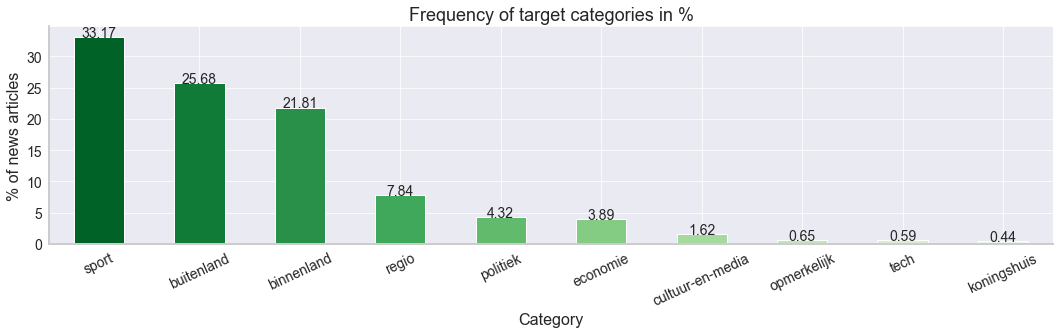

In [6]:
def plot_freq(df, colname):
    set_style("darkgrid")
    plt.figure(figsize=(18,4))
    palette = sns.color_palette("Greens", len(df[colname]))
    rank = df[colname].sort_values(ascending=True).argsort()
    ax = df[colname].sort_values(ascending=False).plot(kind='bar',color=np.array(palette[::-1])[rank] ,fontsize=14)

    # annotate data labels
    for i,child in enumerate(ax.get_children()[:df[colname].size]):
        ax.text(i,child.get_bbox().y1,list(np.round(df[colname].sort_values(ascending=False), decimals=2))[i], horizontalalignment ='center', fontsize=14)

    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['left'].set_linewidth(2)
    plt.ylabel('% of news articles', fontsize=16)
    plt.xlabel('Category', fontsize=16)
    plt.title("Frequency of target categories in %", fontsize=18)
    plt.xticks(rotation=25)
    plt.show()
    
plot_freq(df = pd.DataFrame(df.Category.value_counts(normalize=True))*100, colname = "Category")

Since the four categories with the lowest counts are quite small, let's drop these for further analyses. One could argue that 'Economie' and 'Politiek' should also be dropped, but I suspect these news articles will have a distinct enough corpus in order for a good classifier to predict these categories well. With the selected categories, we cover over 95% of all articles, which is considered sufficient.

In [7]:
df = df[df['Category'].isin(['sport', 'buitenland','binnenland','regio','politiek','economie'])]
print('The resulting dataframe has {} rows and {} columns'.format(df.shape[0],df.shape[1]))

The resulting dataframe has 28259 rows and 5 columns


## 2. Cleaning data

In [8]:
from nltk import FreqDist
from nltk.corpus import stopwords
import spacy

First, we will print an example to show the content of a news article. Since the articles are edited, the data is already quite clean. In the following example we notice that an apostrophe is sometimes preceded by a backward slash. Along with quotation marks, dashes, and other non-alphabetical tokens, these will be removed from the corpus since they don't contain any valuable information for the models. By cleaning the data, we would like te see this message transformed into a series of alphabetical tokens. 

In [9]:
df['Text'][0]

'Na een kortstondig avontuur als hoofdtrainer van Ajax trok Marcel Keizer afgelopen zomer naar het Midden-Oosten. Hij werd trainer van Al-Jazira, een topclub in de Verenigde Arabische Emiraten (VAE).In zijn kielzog werd Damien Hertog, oud-speler van onder meer Excelsior en RBC Roosendaal, zijn assistent. Tot ruim twee weken geleden. Keizer vertrok naar Sporting Portugal, zonder Hertog.Zodoende is Hertog nu plots de hoofdtrainer van Al-Jazira, \'de trots van Abu Dhabi\', zoals vrijwel overal rond het trainingscomplex voor iedereen is te lezen.Verslaggever Martin Vriesema zocht Hertog op in Abu Dhabi, op zijn werkplek. "Eerst zat ik aan het zijkantje", wijst Hertog in het bescheiden kantoortje van de technische staf naar de vergadertafel. "Maar Marcel moest zo nodig naar Sporting, dus hebben we een stoelendans gedaan."Een dans die voor Hertog dus is geëindigd aan het hoofd van de tafel, de plek van de hoofdtrainer.'

For good measure, let's examine the most frequent alphabetical words in the corpus. Not surprisingly, the corpus contains a lot of stop words and other trivial non-domain specific words. By cleaning the data, we would like some more specific words to show up in the frequency counts.

In [10]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    set_style("darkgrid")
    plt.figure(figsize=(18,4))
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    words_df = words_df.nlargest(columns="count", n = terms)
    words_df.set_index('word', inplace=True)
    
    palette = sns.color_palette("Greens", len(words_df['count']))
    rank = words_df['count'].sort_values(ascending=True).argsort()
    ax = words_df['count'].sort_values(ascending=False).plot(kind='bar',color=np.array(palette[::-1])[rank] ,fontsize=14)

    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['left'].set_linewidth(2)
    plt.ylabel('Frequency count', fontsize=16)
    plt.xlabel('Word', fontsize=16)
    plt.title("Frequency of words in corpus", fontsize=18)
    plt.xticks(rotation=25)
    plt.show()

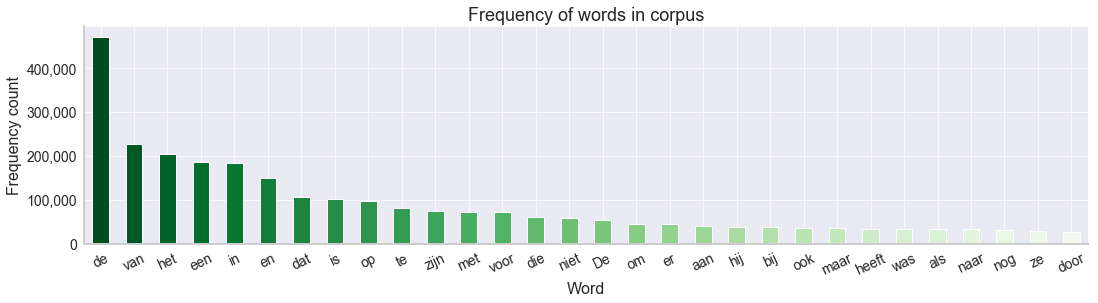

In [11]:
freq_words(df['Text'])

Let's clean the data. I am hesistant to __lemmatize__ or __stem__ the corpus, since the objective is to construct document vectors using word embeddings. __Tomas Mikolov__ - one of the developers of _word2vec_ - hints at cleaning the text not too extensively. For the same reason, __POS - tagging__ is not used to filter out words with a certain Part of Speach tag . <br><br>

_edit: some iterations of model estimation were performed using the lemmatized corpus, but this did not improve the model performance_.

In [12]:
stop_words_extra = ['aan','aangaande','aangezien','al','aldaar','aldus','alhoewel',
 'alias','alle','allebei','alsnog','altijd','altoos','ander','andere','anders',
 'anderszins','behalve','behoudens','beide','beiden','ben','beneden','bent','bepaald','betreffende',
 'bij','binnenin','boven','bovenal','bovendien','bovengenoemd','bovenstaand','bovenvermeld',
 'daar','daarheen','daarin','daarna','daarnet','daarom','daarop','daarvanlangs','dan',
 'dat','de','die','dikwijls','dit','door','doorgaand','dus','echter','eerdat',
 'eerlang','elk','elke','en','enig','enigszins','er','erdoor','even','eveneens',
 'evenwel','gauw','gedurende','gehad','gekund','geleden','gemoeten','gemogen',
 'geweest','gewoon','gewoonweg','haar','had','hadden','hare','heb','hebben','hebt','heeft','hem',
 'hen','het','hierbeneden','hierboven','hij','hoe','hoewel','hun','hunne','ik','ikzelf','in',
 'inmiddels','inzake','is','jezelf','jij','jijzelf','jou','jouw','jouwe','juist','jullie','kan',
 'klaar','kon','konden','krachtens','kunnen','kunt','later','liever','maar','mag','meer','met',
 'mezelf','mij','mijn','mijnent','mijner','mijzelf','misschien','mocht','mochten','moest','moesten',
 'moet','moeten','mogen', 'n', 'na','naar','nadat','net','niet','noch','nog','nogal','nu','of','ofschoon',
 'om','omdat','omstreeks','omtrent','omver','onder','ondertussen','ongeveer','ons',
 'onszelf','onze','ook','op','opnieuw','opzij','over','overigens','pas','precies','reeds',
 'rondom','sedert','sinds','s', 'sindsdien','sommige','spoedig','steeds','tamelijk','tenzij',
 'terwijl','thans','tijdens','toch','toen','toenmaals','toenmalig','tot','totdat','tussen','uit',
 'vaak','van','vandaan','vanuit','vanwege','veeleer','verder','vervolgens','vol',
 'volgens','voor','vooraf','vooral','vooralsnog','voorbij','voordat','voorheen',
 'vrij','vroeg','waar','waarom','wanneer','want','waren','was','wat',
 'wegens','wel', 'we', 'weldra','welk','welke','wie','wiens','wier','wij','wijzelf','zal',
 'ze','zelfs','zichzelf','zij','zijn','zijne','zo','zodra','zonder','zou','zouden','zowat','zulke',
 'zullen','zult', 'zegt']

In [13]:
# remove numbers, punctuation and other non-alphabetical items
df['Text'] = df['Text'].str.replace("[^a-zA-Z#]", " ")
df['Text'] = df['Text'].str.replace("'\'", " ")

# normalize to lowercase
df['Text'] = df['Text'].apply(lambda x: x.lower())

# stop word removal
stop_words = stopwords.words('dutch')
stop_words = stop_words + stop_words_extra
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# remove single letters
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

# lemmatization 
def lemmatize():
    nlp = spacy.load('nl_core_news_sm') 
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word.lemma_ for word in nlp(x)]))

#lemmatize()

After these cleaning steps, let's inspect the data once more. It seems that the most frequent words contain some more domain-specific words, which is good.

In [14]:
df['Text'][0]

'kortstondig avontuur hoofdtrainer ajax trok marcel keizer afgelopen zomer midden oosten trainer jazira topclub verenigde arabische emiraten vae kielzog damien hertog oud speler excelsior rbc roosendaal assistent ruim twee weken keizer vertrok sporting portugal hertog zodoende hertog plots hoofdtrainer jazira trots abu dhabi zoals vrijwel overal rond trainingscomplex iedereen lezen verslaggever martin vriesema zocht hertog abu dhabi werkplek eerst zat zijkantje wijst hertog bescheiden kantoortje technische staf vergadertafel marcel nodig sporting stoelendans gedaan dans hertog indigd hoofd tafel plek hoofdtrainer'

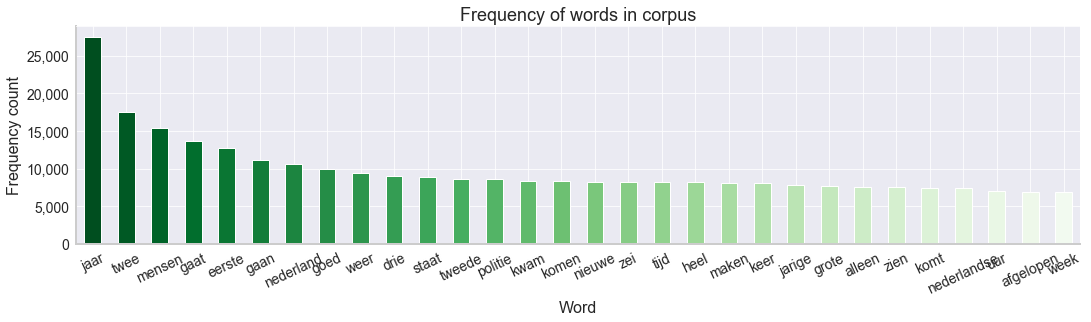

In [15]:
freq_words(df['Text'])

Finally let's split the data for machine learning purposes.

In [16]:
# split data
X_train, X_test, y_train, y_test  = train_test_split(
                            df['Text']
                            , df['Category']
                            , stratify=df['Category']
                            , random_state=77)

# label encode
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

#df.to_csv("../Datasets/NOS_shuffled.csv", index=False, index_label ='index')

## 3. Feature Engineering

In this section, we will be creating several feature sets in order to build the models. It would be interesting to see if feature sets that use more complex techniques (such as word embedding in the case of Doc2Vec) perform better than the more 'ordinary' methods such as Bag of Words. These feature sets can be further combined using unsupervised techniques to maximize model performance, but this is out of scope of this project. My goal here was to get a feel of how these feature sets behave when compared to several models.

For most methods described in this section holds that the hyperparameters were optimized to certain extend (to the best of my Macbook's ability) by using `GridSearchCV` in a `Pipeline` based on a robust classifier.

The following feature sets are constructed in this section:

#### 3.1 Bag of Words 
#### 3.2 Term Frequency - Inverse Document Frequency (TF-IDF)
#### 3.3 Averaged Word Embeddings 
#### 3.4 Topic Models (Latent Dirichlet Allocation) 
#### 3.5 Doc2Vec 

In [17]:
from sklearn import model_selection, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import lda
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import scale
from nltk.corpus import stopwords
import string
import spacy
from keras.preprocessing import text, sequence
from sklearn.externals import joblib
import pickle

Using TensorFlow backend.


In [69]:
# dict to store feature sets in
feature_dct = {}

### 3.1 Bag of Words

For our first feature set, we create a __Bag of Words__ where the rows represent the news articles, and where the columns represent unique words in the corpus, and the cells represent the frequency of the word counts. Notice we are fitting the `CountVectorizer` on the train set. The transform method is called separately for the train set and test set after splitting. This makes sure that the column length is equal for both the `X_train` and `X_test` sets, but more importantly, it prevents `leakage` from the test set into the train set.

In [39]:
count_vectorizer = CountVectorizer( max_df = 1.0
                                   , min_df = 1
                                   , ngram_range = (1,2)
                                   , max_features = 2000) 

count_vect = count_vectorizer.fit(X_train) 

# transform the training and validation data using count vectorizer object
X_train_f1 =  count_vect.transform(X_train)
X_test_f1 =  count_vect.transform(X_test)

# to dataframe
X_train_f1 = pd.DataFrame(X_train_f1.toarray())
X_test_f1 = pd.DataFrame(X_test_f1.toarray())

# check data
print('Resulting dataframe X_train_f1 has {} rows and {} columns'.format(X_train_f1.shape[0]
                                                                         , X_train_f1.shape[1]))
X_train_f1.head()

Resulting dataframe X_train_f1 has 21194 rows and 2000 columns


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [71]:
feature_dct['Bag of Words'] = [X_train_f1, X_test_f1]

### 3.2 Term Frequency - Inverse Document Frequency (TF-IDF)

The TF-IDF score represents the relative importance of a term in the document and the entire corpus. This score is composed of the normalized Term Frequency (TF) and the Inverse Document Frequency (IDF), which is the log of the number of documents in the total corpus divided by the number of documents where the specific term appears.

`TF(t)` = (Number of times term t appears in a document) / (Total number of terms in the document)
<br><br>
`IDF(t)` = log_e(Total number of documents / Number of documents with term t in it)

As with the `CountVectorizer`, we fit the `TfidfVectorizer` on the train set and transform the train and test set separately after fitting the object.

In [50]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000
                                   , min_df = 1
                                   , max_df = 1.0
                                   , ngram_range=(1, 2))
tfidf_vectorizer.fit(X_train)

# transform the training and validation data using count vectorizer object
X_train_f2 =  tfidf_vectorizer.transform(X_train)
X_test_f2 =  tfidf_vectorizer.transform(X_test)

# to dataframe
X_train_f2 = pd.DataFrame(X_train_f2.toarray())
X_test_f2 = pd.DataFrame(X_test_f2.toarray())

# check data
print('Resulting dataframe X_train_f2 has {} rows and {} columns'.format(X_train_f2.shape[0]
                                                                         , X_train_f2.shape[1]))
X_train_f2.head()

Resulting dataframe X_train_f2 has 21194 rows and 2000 columns


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.118536,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.101460,0.130915,0.0,0.0,0.114989,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206995,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [73]:
feature_dct['TF-IDF'] = [X_train_f2, X_test_f2]

### 3.3 Averaged Word Embeddings

The previous features sets are based on frequency distributions. It leaves the model to figure out how and if certain vectors of counts are semantically related. Word embeddings are based on the notion that "a word is characterised by the company it keeps". In Word Embeddings, words that occur in the same context are represented by vectors in close proximity to each other. This should provide the model with more information about how certain words in the corpus have the similar meaning based on the distances of the word vectors.

#### 3.3.1 One vector per unique word

A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. A pre-trained Word embedding model  by __FastText__ is used.

`Wiki.nl.vec` is a dutch word vector with 300 dimensions (columns) containing floats for close to a million words (rows). The word is found in the first position of each line. Source: https://fasttext.cc/docs/en/pretrained-vectors.html

In [75]:
# Loading the pretrained word embeddings
embeddings_index = {}

with open('../Datasets/pre_trained_models/wiki.nl.vec', 'r', encoding="utf8", newline='\n') as file:
    for i, line in enumerate(file):
        values = line.split(' ') 
        if values[0].isalpha(): #only use words that are alphabetical. 
                                # the first value in line is the word
            embeddings_index[values[0]] = np.asarray(values[1:-1], dtype='float32') 
                                # Word as index of dict, ignore last value (empty string).
        
print("Printing first 20 floats for word 'fiets' of total of {} words: \n\n{}".format(len(embeddings_index['fiets']), embeddings_index['fiets'][:20]))

Printing first 20 floats for word 'fiets' of total of 300 words: 

[ 0.72751   0.060679 -0.24799  -0.16265   0.41609   0.32208   0.47915
  0.25152   0.3744   -0.066056 -0.45505  -0.13699  -0.4918   -0.019401
  0.41358   0.46424  -0.18064  -0.02674   0.34107   0.25978 ]


In [76]:
# Creating a tokenizer object
token = text.Tokenizer()
token.fit_on_texts(X_train)
word_index = token.word_index

# dictionary where key = unique word and value = token
print("The dictionary looks like: {}".format(dict(list(word_index.items())[:5])))

The dictionary looks like: {'jaar': 1, 'twee': 2, 'mensen': 3, 'gaat': 4, 'eerste': 5}


In [77]:
# Create a mapping of token and their respective embeddings
embedding_matrix = np.zeros((len(word_index) + 1, 300)) # create empty row for each word in word_index

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) # get vector for each word
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # add to matrix with token as index
        
print("Resulting word embedding matrix looks like:")
pd.DataFrame(embedding_matrix).head() # the index of the matrix is sorted in the dataframe

Resulting word embedding matrix looks like:


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,...,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
1,0.19675,-0.467410,-0.034418,-0.314390,-0.10367,-0.088649,-0.044809,0.43032,0.16537,0.239260,...,0.22761,-0.31373,0.47487,0.080476,-0.106360,0.191540,0.50129,0.035814,-0.013424,0.45983
2,0.29479,-0.111290,0.108520,0.035400,0.24923,0.241640,0.116530,0.26282,0.29628,0.068585,...,0.15078,-0.10782,0.07169,0.079392,-0.041596,0.193390,0.17452,0.026539,-0.386010,0.12392
3,-0.14946,-0.084608,-0.236800,-0.003406,0.26112,0.138470,0.505080,0.02066,0.38317,-0.287970,...,0.04291,-0.09517,0.66337,0.257660,0.028031,-0.058234,0.12953,0.012730,-0.050043,0.14206
4,0.29794,0.074426,-0.342860,-0.103050,0.20629,0.073317,0.353480,-0.12041,0.40991,0.191010,...,-0.16418,-0.12162,0.19880,0.015698,-0.250510,-0.126070,0.24407,-0.202400,-0.052753,0.22424


#### 3.3.2 One document vector (row) per document in corpus

Section 3.3.1 results in a matrix where we obtain one vector per word. Since we need to have one vector per document, we take the average of the vectors of all words in the documents. This results in the document mean vector.

In [78]:
# list of lists with tokens per document
X_train_tokens = [word_tokenize(doc) for doc in X_train] 
X_test_tokens = [word_tokenize(doc) for doc in X_test] 

In [79]:
# Function that transform the documents into word embeddings.
def transformer(tokens):
    doc_means = []
    
    for doc in tokens:
        ls = []
        
        for w in doc:
            ww = w.lower().strip()
            if ww in embeddings_index:
                ls.append(embeddings_index[ww])
        
        arr = np.array(ls)
        doc_mean_vec = np.mean(arr, axis = 0)
        doc_means.append(doc_mean_vec)
        
    doc_means = np.array(doc_means)     
    return pd.DataFrame(doc_means)

X_train_f3 = transformer(X_train_tokens)
X_test_f3 = transformer(X_test_tokens)

# to dataframe
X_train_f3 = pd.DataFrame(X_train_f3) #scale?
X_test_f3 = pd.DataFrame(X_test_f3) #scale?

print('Resulting X_train feature set has {} rows and {} columns'.format(X_train_f3.shape[0], X_train_f3.shape[1]))
X_train_f3.head()

Resulting X_train feature set has 21194 rows and 300 columns


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.229457,-0.208680,0.083898,0.002880,0.282883,0.195580,0.180120,0.153170,0.219868,-0.129106,...,-0.115087,0.026281,0.175809,-0.007885,0.015387,-0.004850,0.139650,-0.051903,-0.145417,-0.047879
1,0.237210,-0.152641,-0.003370,-0.022590,0.204555,0.142159,0.113518,0.176002,0.235740,-0.026234,...,0.068177,-0.187430,0.227247,-0.033927,0.083254,0.042028,0.120275,-0.075542,-0.123172,0.145833
2,0.324875,-0.206733,0.051643,0.011662,0.234295,0.281445,0.290565,0.248254,0.246463,-0.051404,...,0.050520,-0.245141,0.247211,-0.024957,0.049256,0.048618,0.052405,-0.067223,-0.137873,0.019423
3,0.282854,-0.214930,0.043223,-0.015540,0.281971,0.187088,0.237237,0.150102,0.200562,-0.009652,...,0.030464,-0.275556,0.278985,-0.017513,0.104579,-0.019963,0.185413,-0.028480,-0.135023,0.117759
4,0.236052,-0.245587,-0.018274,-0.000984,0.214294,0.227018,0.217021,0.303902,0.303668,-0.140022,...,0.008061,-0.105317,0.242092,-0.057976,0.041013,0.008746,0.153196,-0.099435,-0.123824,-0.025644


In [80]:
feature_dct['Averaged word vector'] = [X_train_f3, X_test_f3]

### 3.4 Topic models - Latent Dirichlet Allocation (LDA)

`Latent Dirichlet Allocation` is a technique that assumes that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. It tries to find latent topics that are assigned to each document, so that each document has a probability distribution for all topics found by LDA. Specifically, one obtains a probability estimate of a document belonging to a certain topic. For this case, we hope to capture the news article categories as topics, but it is certainly possible that many more topics are found, and this will actually benefit the supervised model, since it is quite a stretch to assume that only 6 topics will suffice.

In [94]:
import os
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim
from tqdm import tqdm
pyLDAvis.enable_notebook()

In [95]:
# Tokenize
X_train_tokens = [word_tokenize(doc) for doc in X_train] 

# Converting list of documents (corpus) into Document Term Matrix 
dictionary = corpora.Dictionary(X_train_tokens)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in X_train_tokens]

In [96]:
# Using Mallet's wrapper for Gensim (make sure Java SE 7.0 or higher is installed)
# Download Mallet sklearn wrapper: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

os.environ.update({"MALLET_HOME":r"/Users/gerbentempelman/mallet"}) #edit path
mallet_path = "/Users/gerbentempelman/mallet/bin/mallet" #edit path

In [98]:
def get_coherence_scree(dictionary, corpus, texts, max_topics, start=1, step=10):
    coherence_ls = []
    model_ls = []
    for num_topics in tqdm(range(start, max_topics, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path
                                                 , corpus=corpus
                                                 , num_topics=num_topics
                                                 , id2word=dictionary)
        model_ls.append(model)
        coherencemodel = CoherenceModel(model=model
                                        , texts=texts
                                        , dictionary=dictionary
                                        , coherence='c_v')
        
        coherence_ls.append(coherencemodel.get_coherence())

    return model_ls, coherence_ls

model_ls, coherence_ls = get_coherence_scree(dictionary=dictionary
                                            , corpus=doc_term_matrix
                                            , texts=X_train_tokens
                                            , max_topics=200)




  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [08:35<2:43:21, 515.88s/it]


 10%|█         | 2/20 [18:22<2:41:06, 537.06s/it]


 15%|█▌        | 3/20 [28:08<2:36:20, 551.78s/it]


 20%|██        | 4/20 [37:29<2:27:52, 554.52s/it]


 25%|██▌       | 5/20 [48:33<2:26:50, 587.38s/it]


 30%|███       | 6/20 [1:00:33<2:26:18, 627.04s/it]


 35%|███▌      | 7/20 [1:13:22<2:25:07, 669.85s/it]


 40%|████      | 8/20 [1:27:02<2:22:56, 714.73s/it]


 45%|████▌     | 9/20 [1:41:10<2:18:23, 754.87s/it]


 50%|█████     | 10/20 [1:57:48<2:17:58, 827.85s/it]


 55%|█████▌    | 11/20 [2:12:03<2:05:24, 836.01s/it]


 60%|██████    | 12/20 [2:36:38<2:16:59, 1027.44s/it]


 65%|██████▌   | 13/20 [4:55:55<6:16:25, 3226.54s/it]


 70%|███████   | 14/20 [5:11:27<4:13:49, 2538.20s/it]


 75%|███████▌  | 15/20 [5:27:22<2:51:56, 2063.27s/it]


 80%|████████  | 16/20 [5:45:08<1:57:36, 1764.03s/it]


 85%|████████▌ | 17/20 [6:03:56<1:18:38, 1572.98s/it]


 90%|█████████ | 18/20 [6:23:46<48

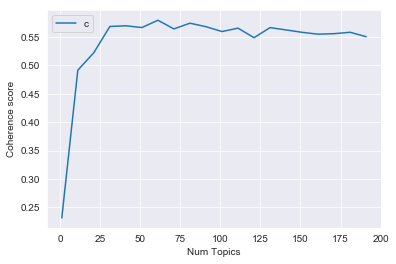

In [99]:
# Show graph to estimate maximum coherence score
x = range(1, 200, 10)
plt.plot(x, coherence_ls)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
# Optimize hyperparameters using scree plot of coherence scores

def get_coherence_scree_2(dictionary, corpus, texts, max_topics):
    coherence_ls = []
    model_ls = []
    for i in tqdm([0, 10, 50, 100, 500, 1000, 2000]):
        model = gensim.models.wrappers.LdaMallet(mallet_path
                                                 , corpus=corpus
                                                 , num_topics=60
                                                 , optimize_interval = i
                                                 , id2word=dictionary)
        model_ls.append(model)
        coherencemodel = CoherenceModel(model=model
                                        , texts=texts
                                        , dictionary=dictionary
                                        , coherence='c_v')
        
        coherence_ls.append(coherencemodel.get_coherence())

    return model_ls, coherence_ls

model_ls_2, coherence_ls_2 = get_coherence_scree_2(dictionary=dictionary
                                            , corpus=doc_term_matrix
                                            , texts=X_train_tokens
                                            , max_topics=200)






  0%|          | 0/7 [00:00<?, ?it/s]




 14%|█▍        | 1/7 [11:34<1:09:24, 694.04s/it]




 29%|██▊       | 2/7 [22:41<57:11, 686.21s/it]  




 43%|████▎     | 3/7 [32:01<43:13, 648.29s/it]




 57%|█████▋    | 4/7 [42:20<31:58, 639.35s/it]




 71%|███████▏  | 5/7 [53:45<21:46, 653.14s/it]




 86%|████████▌ | 6/7 [1:04:52<10:57, 657.30s/it]




100%|██████████| 7/7 [1:35:03<00:00, 1003.26s/it]

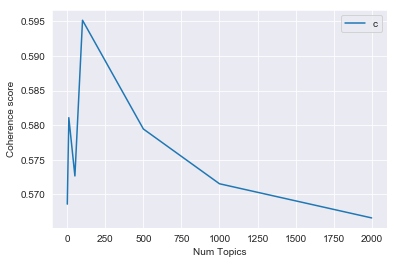

In [122]:
# Show graph to estimate maximum coherence score
x = [0, 10, 50, 100, 500, 1000, 2000]
plt.plot(x, coherence_ls_2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [123]:
for x, y in zip([0, 10, 50, 100, 500, 1000, 2000], coherence_ls_2):
    print(x,y)

0 0.5685969192196344
10 0.5810905294836224
50 0.572670257103159
100 0.5951658178065945
500 0.5794536405262293
1000 0.5715417267895222
2000 0.5666071612538965


In [124]:
# Let's use 60 topics and optimize_interval = x for final Topic model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path 
                                             , corpus=doc_term_matrix
                                             , num_topics=60
                                             , optimize_interval=100
                                             , id2word=dictionary)

ldamallet.show_topics()

[(30,
  '0.039*"verstappen" + 0.016*"formule" + 0.016*"race" + 0.016*"max" + 0.015*"red" + 0.015*"hamilton" + 0.015*"bull" + 0.014*"seizoen" + 0.013*"ferrari" + 0.013*"ricciardo"'),
 (19,
  '0.030*"schiphol" + 0.020*"vluchten" + 0.020*"vliegtuig" + 0.016*"luchthaven" + 0.015*"toestel" + 0.015*"klm" + 0.015*"passagiers" + 0.013*"vliegen" + 0.012*"piloten" + 0.012*"vliegveld"'),
 (5,
  '0.034*"defensie" + 0.017*"militairen" + 0.015*"india" + 0.014*"dieren" + 0.012*"dier" + 0.011*"militaire" + 0.010*"kroon" + 0.009*"indiase" + 0.009*"wolf" + 0.008*"oefening"'),
 (9,
  '0.021*"holleeder" + 0.012*"criminele" + 0.011*"criminelen" + 0.011*"willem" + 0.010*"broer" + 0.010*"astrid" + 0.008*"justitie" + 0.007*"politie" + 0.007*"drugs" + 0.007*"el"'),
 (51,
  '0.035*"school" + 0.035*"studenten" + 0.027*"leerlingen" + 0.025*"scholen" + 0.024*"onderwijs" + 0.013*"kinderen" + 0.012*"leraren" + 0.011*"universiteit" + 0.010*"jongeren" + 0.010*"ouders"'),
 (33,
  '0.029*"mensen" + 0.011*"heel" + 0.010*

In [125]:
# get probabilities per topic for train set
X_train_f4 = pd.DataFrame(ldamallet[doc_term_matrix])
X_train_f4 = X_train_f4.applymap(lambda x: x[1:][0])
print('X_train set has {} rows and {} columns and looks like'.format(X_train_f4.shape[0]
                                                                     , X_train_f4.shape[1]))
X_train_f4.head()

X_train set has 21194 rows and 60 columns and looks like


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.000500,0.004828,0.000348,0.000282,0.000248,0.000185,0.003520,0.000516,0.002272,0.000190,...,0.000286,0.000196,0.000243,0.000271,0.001342,0.532116,0.000431,0.000281,0.117436,0.000211
1,0.000535,0.000654,0.000373,0.001431,0.001395,0.000198,0.002641,0.000553,0.001304,0.000203,...,0.000306,0.000210,0.000261,0.002549,0.000308,0.001875,0.000461,0.000301,0.007202,0.002485
2,0.000357,0.000437,0.184959,0.000201,0.000178,0.000132,0.232462,0.001123,0.001625,0.000135,...,0.000204,0.000140,0.000174,0.000194,0.000206,0.002006,0.000308,0.000955,0.013854,0.000151
3,0.000445,0.001482,0.000310,0.000251,0.000221,0.000165,0.002194,0.000460,0.001084,0.000169,...,0.000255,0.000175,0.189816,0.000241,0.001195,0.000620,0.000383,0.000250,0.016310,0.000188
4,0.000334,0.000409,0.000233,0.000189,0.000166,0.000830,0.137911,0.000346,0.180143,0.000127,...,0.000191,0.000131,0.000869,0.000887,0.000192,0.001172,0.000288,0.000188,0.022152,0.000141


In [126]:
# Get probabilities per topic for test set
X_test_tokens = [word_tokenize(doc) for doc in X_test] 
doc_term_matrix_test = [dictionary.doc2bow(doc) for doc in list(X_test_tokens)]

# create feature test set
X_test_f4 = pd.DataFrame(ldamallet[doc_term_matrix_test])
X_test_f4 = X_test_f4.applymap(lambda x: x[1:][0])
print('X_test set has {} rows and {} columns'.format(X_test_f4.shape[0], X_test_f4.shape[1]))

X_test set has 7065 rows and 60 columns


In [ ]:
# Visualize the topics

# run optionally, since there are 50 topics that are purely functioning as features,
# the contents of the topics might not be that interesting.

from_mallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
vis = pyLDAvis.gensim.prepare(from_mallet, doc_term_matrix, dictionary)
#pyLDAvis.display(vis)

In [105]:
feature_dct['Gensim Mallet LDA'] = [X_train_f4, X_test_f4]

### 3.5 Doc2Vec

__About the Paragraph Vector__<br>
The approach used in section 2.3.2 (Word Embedding) of averaging each Document's words' word-vectors results in a document-vector is neat. However, Le and Mikolov (2014) introduced the Paragraph Vector, which is a more sophisticated method that generally outperforms simple averaging of word vectors. Generally, one can think of a document having another world-like vector that is specific to the document. This is called the Paragraph Vector.

There are two types of Paragraph Vectors: DBOW and DM. Distributed Bag of Words (DBOW) in Doc2Vec is similar to Word2Vec's Skip-Gram (SG). Also, Distributed Memory (DM) in Doc2Vec is similar to Word2Vec's ontinuous Bag of Words (CBOW). For each method in Doc2Vec, one model is build, whereafter both models are combined, which generally yields better results.<br><br>

__Distributed Bag of Words (PV-DBOW)__<br>
The Paragraph vectors are based on the task of predicting a target word just from the full document's doc-vector. It is a task of predicting a probability distribution of words in a document given a randomly-sampled word from the document.<br><br>

__Distributed Memory (PV-DM)__<br>
The Paragraph vectors are based on the task of predicting a center word based an average of both context word-vectors and the full document's doc-vector. DM remembers what is missing in the current context — or as the topic of the document. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. 

Notice the words 'Paragraph' and 'Document' are used interchangeably here.

In [18]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import nltk
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
import multiprocessing
cores = multiprocessing.cpu_count()

In [107]:
# first, tag documents with its category (target)
def tag_documents(X, y):
    # recreate dataframe with Text and category label 
    X_ser = X.reset_index(drop=True)
    X_d2v = pd.concat([X_ser, pd.Series(y)], axis=1)
    X_d2v.columns = ['Text', 'Category']
    
    # tag each document with its label
    tagged_documents = X_d2v.apply(lambda x: TaggedDocument(
                                    words=word_tokenize(x['Text'])
                                    , tags=[x.Category])
                                    , axis=1)
    
    return tagged_documents

train_tagged = tag_documents(X_train, y_train)
test_tagged = tag_documents(X_test, y_test)

In [108]:
# example of tagged document with text and with tagged Category
train_tagged.values[30]

TaggedDocument(words=['kiki', 'bertens', 'finale', 'bereikt', 'hardcourttoernooi', 'seoul', 'wateringse', 'zuid', 'koreaanse', 'hoofdstad', 'tweede', 'geplaatst', 'knokte', 'foutenfestival', 'stuks', 'totaal', 'langs', 'maria', 'sakkari', 'bertens', 'derde', 'geplaatste', 'griekse', 'vier', 'eerdere', 'duels', 'twee', 'keer', 'verslagen', 'leverde', 'drie', 'eerste', 'vier', 'opslagbeurten', 'won', 'laatste', 'drie', 'games', 'eerste', 'set', 'tweede', 'bedrijf', 'ging', 'soepel', 'landgenote', 'sakkari', 'speelde', 'veelal', 'slordiger', 'lukte', 'bertens', 'partij', 'serveren', 'game', 'brak', 'griekse', 'zevende', 'keer', 'vierde', 'finale', 'feit', 'bertens', 'seoul', 'derde', 'toernooi', 'tennisjaar', 'winnen', 'eerder', 'sterkste', 'cincinnati', 'charleston', 'madrid', 'verloor', 'finale', 'ajla', 'tomljanovic', 'roet', 'eten', 'gooien', 'australische', 'tegenstandster', 'finale', 'bertens', 'hoopt', 'komende', 'weken', 'azi', 'deelname', 'af', 'dwingen', 'wta', 'finals', 'grijpt

#### 3.6.1 DBOW

In [109]:
def build_d2v(train_tagged=train_tagged, dm=0, vector_size=50, negative=0, hs=1, seed = 77
             ,min_count=1, min_alpha=0.0001, alpha = 0.065, epochs = 30, sample=0, workers=cores):
    # default is dbow (dm=0), dm=1 equals Distributed Memory

    print(">>instantiating model..<<")
    model = Doc2Vec(dm=dm, vector_size=vector_size, negative=negative, hs=hs
                     , min_count=min_count, sample = sample, workers=workers
                    ,epochs = epochs, min_alpha = min_alpha, seed = seed, alpha = alpha) 
    #alpha = 0.025, min_alpha = 0.025, dm_mean=1, vector_size=300, window=10, alpha
    
    print(">>building vocabulary..<<")
    model.build_vocab([x for x in train_tagged.values])
    
    print(">>training model..<<")
    model.train(utils.shuffle([x for x in train_tagged.values], random_state = seed)
                 , total_examples=len(train_tagged.values), epochs=model.epochs)
    
    print(">>finished building Doc2Vec model<<")
    return model

model_dbow = build_d2v()

## Building feature vector for classifier
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

y_train_d2v, X_train_d2v = vec_for_learning(model_dbow, train_tagged)
y_test_d2v, X_test_d2v = vec_for_learning(model_dbow, test_tagged)

>>instantiating model..<<
>>building vocabulary..<<
>>training model..<<
>>finished building Doc2Vec model<<


#### 3.6.2 DM

In [110]:
# Distibuted memory variant
model_dm = build_d2v(dm=1) #dm_mean=1,alpha=0.065,window=10,

y_train_d2v, X_train_d2v = vec_for_learning(model_dm, train_tagged)
y_test_d2v, X_test_d2v = vec_for_learning(model_dm, test_tagged)

>>instantiating model..<<
>>building vocabulary..<<
>>training model..<<
>>finished building Doc2Vec model<<


#### 3.6.3 Combining DBOW and DM

Sometimes combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) improves performance. We will follow, pairing the models together for evaluation.

In [111]:
# free up RAM
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# combine models
new_model = ConcatenatedDoc2Vec([model_dbow, model_dm])

In [112]:
y_train_d2v, X_train_d2v = vec_for_learning(new_model, train_tagged)
y_test_d2v, X_test_d2v = vec_for_learning(new_model, test_tagged)

X_train_f5 = pd.DataFrame(np.array(X_train_d2v))
X_test_f5 = pd.DataFrame(np.array(X_test_d2v))

print('Resulting X_train dataframe has {} columns and {} rows'.format(X_train_f5.shape[1]
                                                                      , X_train_f5.shape[0]))
X_train_f5.head()

Resulting X_train dataframe has 100 columns and 21194 rows


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.073534,-1.396484,-1.107511,0.329510,1.610590,0.607696,0.556523,-0.710920,0.046802,-0.961468,...,-0.917453,1.260043,0.008999,-0.123987,1.266527,2.698158,1.544585,-1.836318,-3.029305,-0.886853
1,-0.624369,-0.752067,1.155481,-0.393155,-1.084836,-0.210337,-1.023318,-0.466461,-0.998137,0.057015,...,-1.050536,0.852714,1.373693,2.420187,-0.315025,3.338389,1.338996,0.948372,3.471061,1.660041
2,-0.741350,1.584534,-0.436112,0.876154,0.732825,0.266201,-0.412043,-0.371027,0.360098,0.020720,...,0.991118,-1.010242,-0.693474,-0.559834,-0.156373,0.358388,0.661286,-0.986505,0.876554,0.131441
3,0.374422,0.224575,-0.597916,1.045511,-0.494429,-0.261761,-0.267305,0.079838,0.002930,-1.342130,...,-0.985702,0.373113,-0.271825,0.594301,1.025216,-0.302048,1.537123,-0.552988,-1.305961,0.946120
4,-0.729131,-0.066831,-1.388950,-0.128210,-0.707178,0.638431,-0.471189,-0.023343,-0.506728,-0.215676,...,3.342274,0.367762,-1.522566,0.352244,-1.989156,0.489866,0.622809,1.381885,-1.054426,0.164902


In [113]:
feature_dct['Doc2Vec'] = [X_train_f5, X_test_f5]

## 4. Model Building

Build different models on different feature sets. To evaluate these models, the `F1 macro` score is used, since we would like a sense of how the classifiers perform over all categories that are to be predicted.

In [18]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from keras import layers, models, optimizers
from sklearn.metrics import accuracy_score
import logging
from sklearn.preprocessing import StandardScaler

In [115]:
# define F1 scorer function
def print_scores(clf, X_train, y_train, X_test, y_test, is_neural_net=False, verbose = True):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if verbose == True:
        print('F1 macro score: {:3f}'.format(f1_score(y_test, y_pred, average="macro"))) 
    return f1_score(y_test, y_pred, average="macro")*100 

In [127]:
print('Feature dictionary contains the following feature sets: \n')
print(list(feature_dct.keys()))

Feature dictionary contains the following feature sets: 

['Bag of Words', 'TF-IDF', 'Averaged word vector', 'Gensim Mallet LDA', 'Doc2Vec']


In [128]:
# scale
sc = StandardScaler()
feature_dct_sc = {}

for f in feature_dct.keys():
    feature_dct_sc[str(f)+' scaled'] = [sc.fit_transform(feature_dct[str(f)][0])
                              , sc.transform(feature_dct[str(f)][1])]
    
print(list(feature_dct_sc.keys()))

['Bag of Words scaled', 'TF-IDF scaled', 'Averaged word vector scaled', 'Gensim Mallet LDA scaled', 'Doc2Vec scaled']


In [129]:
# Train all models on all feature sets
models_ls = {"LDA": LinearDiscriminantAnalysis()
            ,"Stochastic Gradient Descent (SGD)": SGDClassifier(loss = 'hinge'
                                                                , penalty='elasticnet'
                                                                , max_iter = np.ceil(10**6 / len(X_train))
                                                                , class_weight='balanced'
                                                                , random_state = 77)
            , "SVC C=1 balanced": SVC(C=1, class_weight = 'balanced', random_state=77)
            ,"SVC C=10 balanced": SVC(C=10, class_weight = 'balanced', random_state=77)
            , "SVC C=1": SVC(C=1, random_state=77)
            , "SVC C=10": SVC(C=10, random_state=77)  
             ,"Logistic Regression C=0.1": LogisticRegression(C = 0.1, solver='lbfgs', random_state=77,  multi_class='multinomial') 
             ,"Logistic Regression C=1": LogisticRegression(C = 1, solver='lbfgs', random_state=77,  multi_class='multinomial') 
              ,"Logistic Regression C=10": LogisticRegression(C = 10, solver='lbfgs', random_state=77,  multi_class='multinomial')             
             , "MultiLayerPerceptron": MLPClassifier(solver = 'lbfgs', random_state=77)
                }


# setup
model_results = pd.DataFrame()
model = []
cnt = 0

for fdata in tqdm(feature_dct_sc.values()):
    cnt += 1
    scores = []
    for x, m in zip(models_ls, models_ls.values()):
        print(x)
        score = print_scores(m, fdata[0], y_train, fdata[1], y_test, verbose = False)
        if cnt == 1:
            model.append(x)
        scores.append(score)
    model_results['feature_set{}'.format(cnt)] = scores       
model_results.index = model
model_results.columns = list(feature_dct_sc)

model_results






  0%|          | 0/5 [00:00<?, ?it/s]

LDA
Stochastic Gradient Descent (SGD)
SVC C=1 balanced
SVC C=10 balanced
SVC C=1
SVC C=10
Logistic Regression C=0.1
Logistic Regression C=1
Logistic Regression C=10
MultiLayerPerceptron







 20%|██        | 1/5 [3:02:52<12:11:31, 10972.85s/it]

LDA
Stochastic Gradient Descent (SGD)
SVC C=1 balanced
SVC C=10 balanced
SVC C=1
SVC C=10
Logistic Regression C=0.1
Logistic Regression C=1
Logistic Regression C=10
MultiLayerPerceptron







 40%|████      | 2/5 [4:38:24<7:50:01, 9400.57s/it]  

LDA
Stochastic Gradient Descent (SGD)
SVC C=1 balanced
SVC C=10 balanced
SVC C=1
SVC C=10
Logistic Regression C=0.1
Logistic Regression C=1
Logistic Regression C=10
MultiLayerPerceptron







 60%|██████    | 3/5 [4:45:34<3:43:38, 6709.18s/it]

LDA
Stochastic Gradient Descent (SGD)
SVC C=1 balanced
SVC C=10 balanced
SVC C=1
SVC C=10
Logistic Regression C=0.1
Logistic Regression C=1
Logistic Regression C=10
MultiLayerPerceptron







 80%|████████  | 4/5 [4:48:22<1:19:07, 4747.10s/it]

LDA
Stochastic Gradient Descent (SGD)
SVC C=1 balanced
SVC C=10 balanced
SVC C=1
SVC C=10
Logistic Regression C=0.1
Logistic Regression C=1
Logistic Regression C=10
MultiLayerPerceptron







100%|██████████| 5/5 [4:50:34<00:00, 3362.29s/it]  

,Bag of Words scaled,TF-IDF scaled,Averaged word vector scaled,Gensim Mallet LDA scaled,Doc2Vec scaled
LDA,78.228707,80.502732,75.845118,67.463082,74.594362
Stochastic Gradient Descent (SGD),76.161375,75.925834,73.959810,65.812456,72.246205
SVC C=1 balanced,79.415722,80.775742,78.493505,68.049290,75.940809
SVC C=10 balanced,78.524907,79.672041,79.418732,70.723796,73.563735
SVC C=1,77.300164,79.019239,78.453166,70.782168,74.438547
SVC C=10,78.361886,79.663381,79.558380,72.161349,73.519990
Logistic Regression C=0.1,72.667087,71.608598,75.691497,65.887655,72.225121
Logistic Regression C=1,70.196303,69.225044,75.452535,66.218289,71.957036
Logistic Regression C=10,70.038136,69.140709,75.576348,66.146890,72.037497
MultiLayerPerceptron,77.898084,76.685372,75.406295,67.518203,71.131721


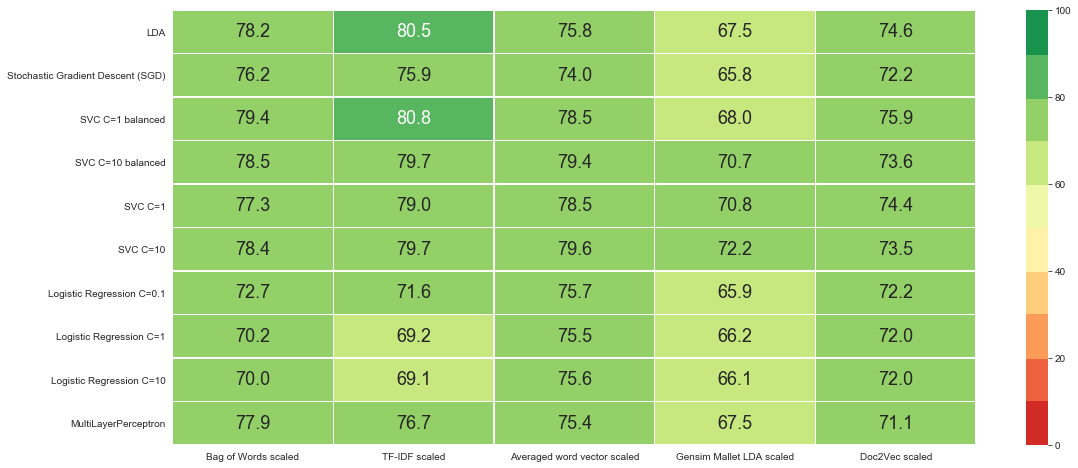

In [130]:
# Plot model training results (F1 macro score)
set_style("darkgrid")
plt.figure(figsize=(18,8))
palette = sns.color_palette("RdYlGn", 10)
sns.heatmap(model_results, vmin=0, vmax=100, center = 50
            , annot=True, fmt='.1f', linewidths=.5, cmap=palette, annot_kws={"size": 18});

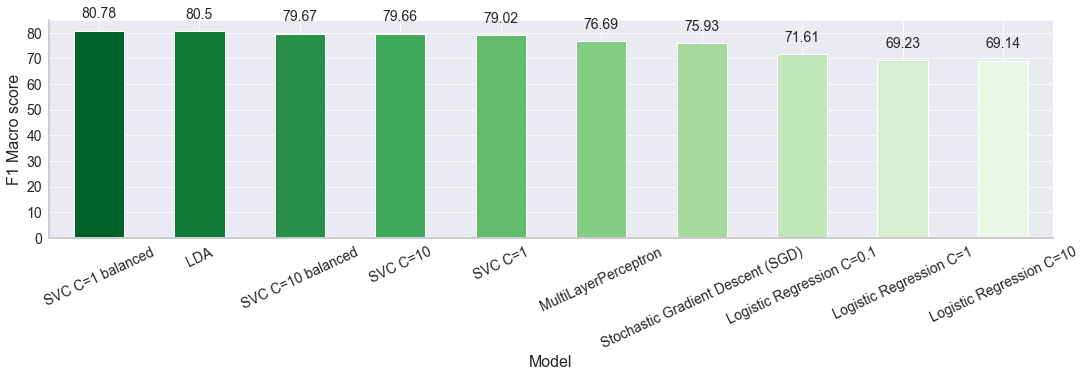

In [131]:
def plot_model_comparison(df, colname):
    set_style("darkgrid")
    plt.figure(figsize=(18,4))
    palette = sns.color_palette("Greens", len(df[colname]))
    rank = df[colname].sort_values(ascending=True).argsort()
    ax = df[colname].sort_values(ascending=False).plot(kind='bar',color=np.array(palette[::-1])[rank] ,fontsize=14)

    # annotate data labels
    for i,child in enumerate(ax.get_children()[:df.index.size]):
        ax.text(i,child.get_bbox().y1+5,list(np.round(df[colname].sort_values(ascending=False), decimals=2))[i], horizontalalignment ='center', fontsize=14)

    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['left'].set_linewidth(2)
    plt.ylabel('F1 Macro score', fontsize=16)
    plt.xlabel('Model', fontsize=16)
    plt.xticks(rotation=25)
    plt.show()
    
plot_model_comparison(df = model_results, colname = 'TF-IDF scaled')

#### 4.2 Hyperparameter optimization

As an optional extra, let's tune the most succesful models from the previous steps. I decided not to execute this part, since it would take too much of my laptop to process, but feel fry to search for a better configuration of the model.

In [132]:
def tune_hyperparameters():
    param_grid = param_grid = {'C':[0.1, 1, 10]
                               ,'gamma':[1,0.1,0.001,0.0001]
                               , 'kernel':['linear','rbf']}

    gs = GridSearchCV(SVC(class_weight = 'balanced', random_state=77), 
                 param_grid=param_grid, scoring="f1_macro", cv=5, n_jobs=-1, verbose=10)
    gs = gs.fit(feature_dct_sc['TF-IDF scaled'][0], y_train)
    print(gs.best_params_)
    print('best score: {:3f}'.format(gs.best_score_))
    return gs.best_estimator_

#finalmodel = tune_hyperparameters()

In [133]:
# create and export final model
finalmodel=SVC(C=1, class_weight = 'balanced', random_state=77)
finalmodel.fit(pd.DataFrame(feature_dct_sc['TF-IDF scaled'][0]), y_train)
joblib.dump(finalmodel, 'dash-nos/clf_nos.joblib', compress=9)

['dash-nos/clf_nos.joblib']

In [84]:
import _pickle as pickle
import bz2
        
with bz2.BZ2File('dash-nos/tfidf_vectorizer_nos.pkl', 'w') as f:
    pickle.dump(tfidf_vectorizer, f)

In [135]:
# export scaler for Dash app
sc = StandardScaler()
sc.fit(feature_dct['TF-IDF'][0])
joblib.dump(sc, 'dash-nos/scaler_nos.pkl', compress=9)

['dash-nos/scaler_nos.pkl']

#### 4.3 Confusion matrix inspection

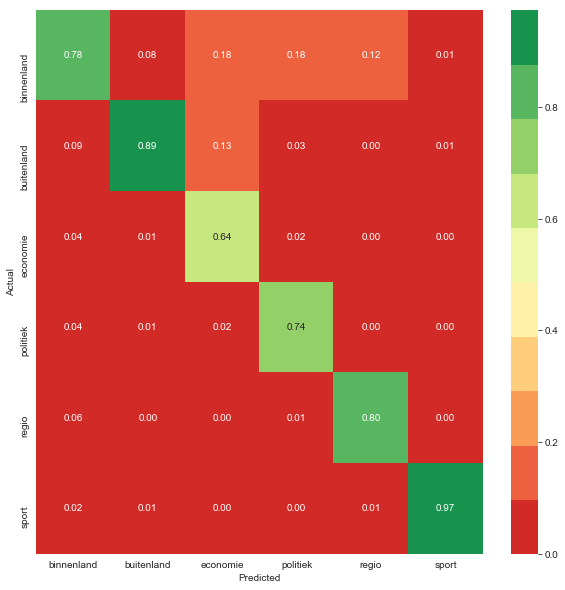

In [136]:
# confusion matrix
from sklearn.metrics import confusion_matrix
palette = sns.color_palette("RdYlGn", 10)

y_pred = finalmodel.predict(feature_dct_sc['TF-IDF scaled'][1])

l1 = encoder.inverse_transform(y_test)
l2 = encoder.inverse_transform(y_pred)
C = confusion_matrix(l1, l2, labels=np.unique(l2))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(C / C.astype(np.float).sum(axis=1)
            , fmt ='.2f', annot=True, cmap=palette
            , xticklabels=np.unique(l1), yticklabels=np.unique(l1))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 5. Dimensionality reduction & plotting

We will be using a projection techique to reduce dimensionality in the dataset in order to be able to plot the news articles. Some attempts were made using _t-distributed stochastic neighbor embedding_ (T-SNE), in combination with the bokeh plotting library, but results were not great. After some research, I came across a technique called _Uniform Manifold Approximation and Projection_ (UMAP). UMAP is used in combination with Dash to plot the vector space, since Bokeh didn't seem to have implemented a 3D scatter plot.

In [19]:
import umap

In [20]:
# TFIDF on whole dataset
tfidf_vectorizer = TfidfVectorizer(max_features = 5000,
                                min_df = 1
                               , max_df = 1.0
                               , ngram_range=(1, 2)
                                  ) 

df_tfidf = tfidf_vectorizer.fit_transform(df['Text'])
df_tfidf = pd.DataFrame(df_tfidf.toarray())

In [23]:
## UMAP
embedding = umap.UMAP(n_components = 3
                      , n_neighbors=300 #400 
                      , min_dist=0.001 #0.1 
                      , metric='cosine'
                      , random_state=77).fit_transform(df_tfidf)
#n_neighbors = range 5 to 50, with a choice of 10 to 15 being a sensible default.
#min_dist = 0.001 to 0.5, with 0.1 sensible default

umap_df = pd.DataFrame(embedding
                       , columns = ['umap_1', 'umap_2', 'umap_3']
                       ,index=pd.DataFrame(df).index)

umap_df = df.drop(columns=['Date', 'Text']).join(umap_df)
umap_df.set_index('Category', inplace=True)
umap_df.to_csv("dash-nos/umap_df.csv", index=True, header=True)

encoder = preprocessing.LabelEncoder()
labels = encoder.fit(df['Category'])
joblib.dump(encoder, 'dash-nos/encoder_nos.pkl', compress=9)

['dash-nos/encoder_nos.pkl']

In [24]:
# Dataframe that is used as input for Dash
umap_df.head()

,Title,Link,umap_1,umap_2,umap_3
Category,,,,,
sport,Na vertrek Keizer staat Damien Hertog plots aan het roer bij Al-Jazira,https://www.nos.nl/artikel/2261038-na-vertrek-keizer-staat-damien-hertog-plots-aan-het-roer-bij-al-jazira.html,1.684431,-2.584979,-1.940090
economie,"Eerst waren de Saudische miljarden welkom, nu is de techwereld stil",https://www.nos.nl/artikel/2256069-eerst-waren-de-saudische-miljarden-welkom-nu-is-de-techwereld-stil.html,-2.360937,0.161668,-2.776365
buitenland,Duitse minister: ondertekenen migratiepact desnoods uitstellen,https://www.nos.nl/artikel/2259899-duitse-minister-ondertekenen-migratiepact-desnoods-uitstellen.html,-3.164507,1.050445,-0.862348
sport,Buijs hekelt gedrag Gözübüyük na terugdraaien rood bij VVV-FC Groningen,https://www.nos.nl/artikel/2262753-buijs-hekelt-gedrag-gozubuyuk-na-terugdraaien-rood-bij-vvv-fc-groningen.html,1.954242,-2.049429,-2.812590
regio,Fotograaf zoekt dubbelgangers van figuren op de Nachtwacht,https://www.nos.nl/artikel/2263948-fotograaf-zoekt-dubbelgangers-van-figuren-op-de-nachtwacht.html,-0.842751,2.034566,-0.744917


The result is a Dash dashboard showing all news articles in a 3D scatter plot based on their semantic density. One is able to distinguish certain topics. On the right is a UI were the user is able to create their own message in order to let the machine learning model predict what category it belongs to.